# Quantum State Tomography with Iterative Maximum Likelihood Estimation.

Author: Shahnawaz Ahmed  
Email: shahnawaz.ahmed95gmail.com  
GitHub: quantshah  

In this notebook, we use QuTiP to perform Quantum State Tomography by counting photon number statistics of a resonator as discussed in [1]. The iterative Maximum Likelihood Estimation method is used to start from a random guess of the density matrix and repeatedly apply an operator to obtain the true density matrix of the state [2].  

![SegmentLocal](images/reconstruction.gif "segment")


We measure the probability of observing a certain number of photons $\langle n \rangle$ after displacing the state by various angles. This is done by applying the displacement operator to the density matrix of the state $D(\beta) \rho D^{\dagger}(\beta)$. Then, using the photon number statistics for various measurement settings, i.e., values of $\beta_i$, we can recreate the density matrix.

![photonstats](images/photon-stats.png "photon-stats")


This is done by an iterative Maximum Likelihood method by repeatedly applying an operator $R$ which is a function of the measured value of the observable $f_i$, current estimate of the probability from the density matrix, $p_i$ and measurement setting (the displaced basis in this case $|y_i \rangle \langle y_i| D(\beta) |n_i \rangle \langle n_i|  D^{\dagger}(\beta))$, where $n_i$ denotes the fock basis operator for measuring $i$ photons.

![rop](images/rop.png "rop")


## References
[1] Shen, Chao, et al. "Optimized tomography of continuous variable systems using excitation counting." Physical Review A 94.5 (2016): 052327.  
Link: https://arxiv.org/abs/1606.07554

[2] Řeháček, J., Z. Hradil, and M. Ježek. "Iterative algorithm for reconstruction of entangled states." Physical Review A 63.4 (2001): 040303.

In [13]:
import numpy as np

from qutip import Qobj, rand_dm, fidelity, displace, qdiags, qeye, expect
from qutip.states import coherent, coherent_dm, thermal_dm, fock_dm
from qutip.visualization import plot_wigner, hinton
from qutip.wigner import qfunc
import qutip

import matplotlib.pyplot as plt
from matplotlib import animation

# some pretty printing and animation stuff
from IPython.display import clear_output

# Define the operator measured, how to obtain it from a density matrix and the iterative operator for MaxLikelihood.

In [14]:
"""
Iterative Maximum Likelihood estimation based on photon number counting.
"""


def measure_population(beta, rho):
    """
    Measures the photon number statistics for state rho when displaced
    by angle alpha.
    
    Parameters
    ----------    
    alpha: np.complex
        A complex displacement.

    rho:
        The density matrix as a QuTiP Qobj (`qutip.Qobj`)

    Returns
    -------
    population: ndarray
        A 1D array for the probabilities for populations.
    """
    hilbertsize = rho.shape[0]
    # Apply a displacement to the state and then measure the diagonals.

    D = displace(hilbertsize, beta)
    rho_disp = D*rho*D.dag()
    populations = np.real(np.diagonal(rho_disp.full()))
    return populations

def roperator(beta, rho, measured):
    """
    Calculates the iterative ratio operator for measured probability for photons
    (j) to the analytical prediction for some rho.

    Parameters
    ----------
    beta: list_like
        A list of the displacements that were applied to the state before
        measurement.

    rho: `qutip.Qobj`
        The current estimate of the density matrix.

    measured: list_like
        A list of the measurement statistics (diagonal terms) for each beta.

    Returns
    -------
    R: `qutip.Qobj`
        The iterative operator which we are going to apply for state
        reconstruction.
    """
    hilbert_size = rho.shape[0]

    # initialize an empty operator and build it

    R = 0*qeye(hilbert_size)
    calculated_measurements = measure_population(beta, rho)

    for n in range(hilbert_size):
        op = fock_dm(hilbert_size, n)
        D = displace(hilbert_size, beta)
        displaced_D = D.dag()*op*D
        ratio = measured[n]/(calculated_measurements[n] + 1e-6)
        displaced_D = ratio*displaced_D
        R += displaced_D

    return R

# Take an example density matrix and reconstruct it

In [15]:
hilbert_size = 32
alpha_range = 1.9

alphas = np.array([alpha_range, -alpha_range - 1j*alpha_range,
                   -alpha_range + 1j*alpha_range])

rho_true = sum([coherent_dm(hilbert_size, a) for a in alphas])/3

# Displace and measure populations

In [16]:
betas = [1.7, -2, 2.2j, -2.1 - 2.4j, -2 + 2j]
measured_populations = [measure_population(b, rho_true) for b in betas]
width = 1

# Random initial state

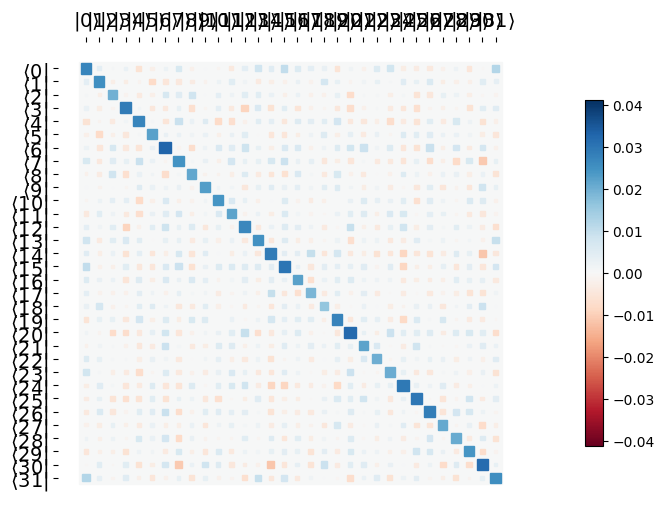

In [17]:
random_rho = rand_dm(hilbert_size)
hinton(random_rho)
plt.show()

# Wigner function plot and measurement statistics

The x marks the displacement angles.

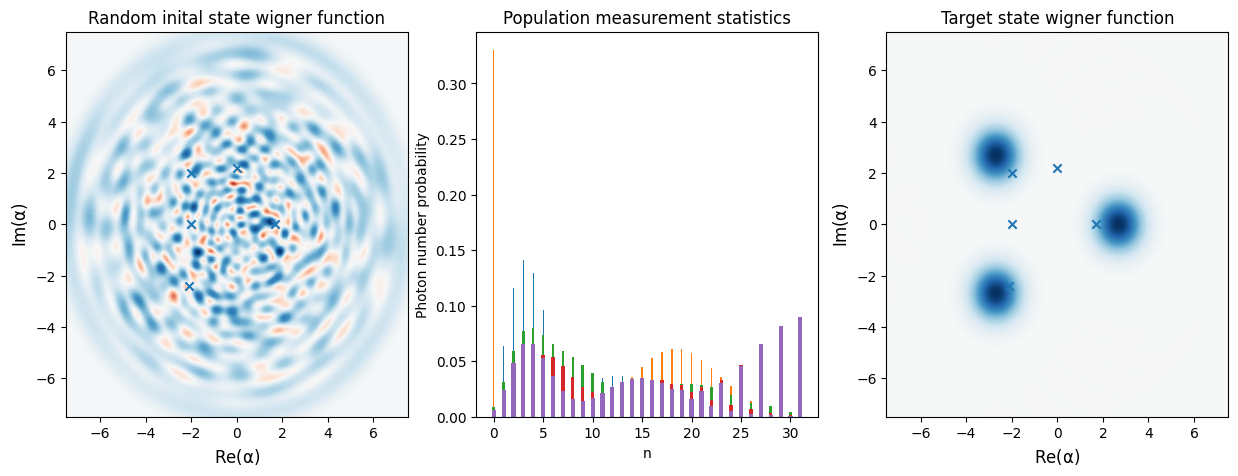

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
indices = np.arange(hilbert_size)

plot_wigner(random_rho, fig, ax[0])
ax[0].scatter(np.real(betas), np.imag(betas), marker="x")
ax[0].set_title("Random inital state wigner function")
for i in range(len(betas)):
    ax[1].bar(indices, measured_populations[i],
              label = r"$beta = {}$".format(i), width=(i+1)/12)

ax[1].set_title("Population measurement statistics")
ax[1].set_xlabel("n")
ax[1].set_ylabel("Photon number probability")


plot_wigner(rho_true, fig, ax[2])
ax[2].scatter(np.real(betas), np.imag(betas), marker="x")
ax[2].set_title("Target state wigner function")
plt.show()

# The actual MLE iterations for various measurement settings

In [19]:
rho_t = []

In [20]:
max_iter = 100

for iterations in range(max_iter):
    for i in range(len(betas)):
        rho_t.append(random_rho)
        rop = roperator(betas[i], random_rho, measured_populations[i])
        random_rho = rop*random_rho*rop
        
        # Trace renorm
        random_rho = random_rho/random_rho.tr()
        # Compute fidelity
        fidel = fidelity(random_rho, rho_true)

        if iterations % 5 == 0:
            print(r"Fidelity: {}".format(fidel))
            clear_output(wait=0.2)

    if fidel > 0.99:
        break

Fidelity: 0.989306043605491


# Reconstructed states

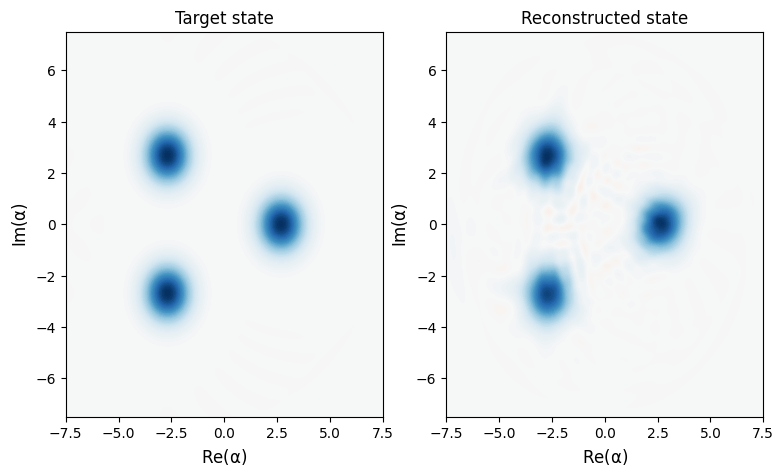

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
plot_wigner(random_rho, fig=fig, ax=ax[1])
plot_wigner(rho_true, fig=fig, ax=ax[0], cmap="RdBu")

ax[0].set_title("Target state")
ax[1].set_title("Reconstructed state")

plt.show()

# Population measurement from reconstructed states

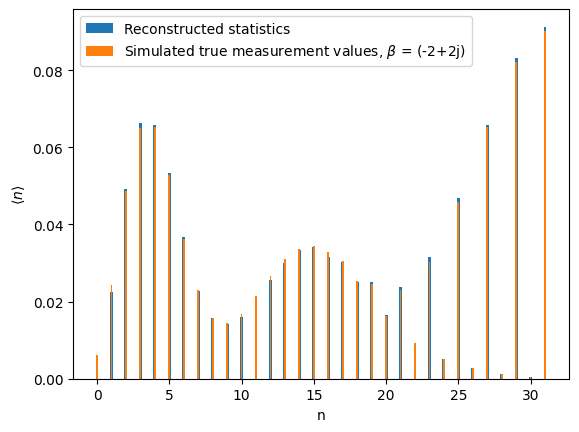

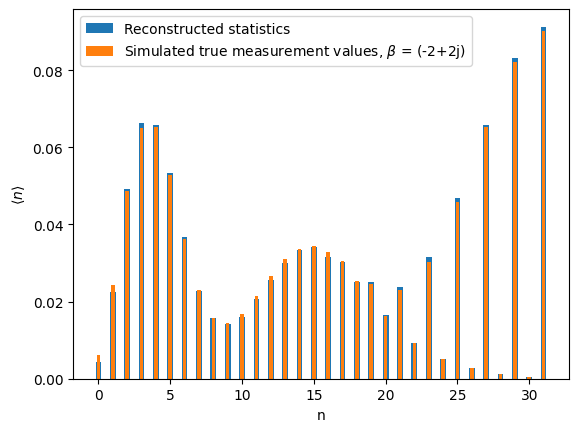

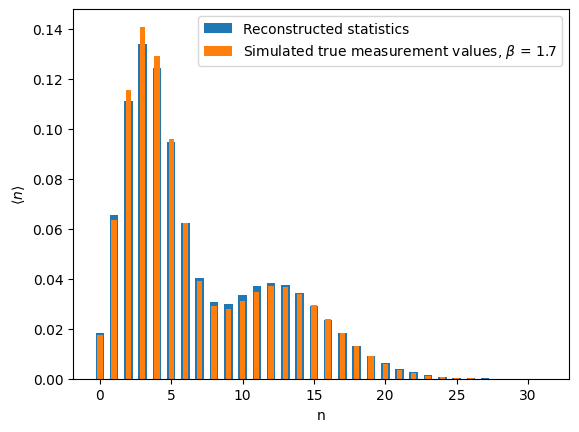

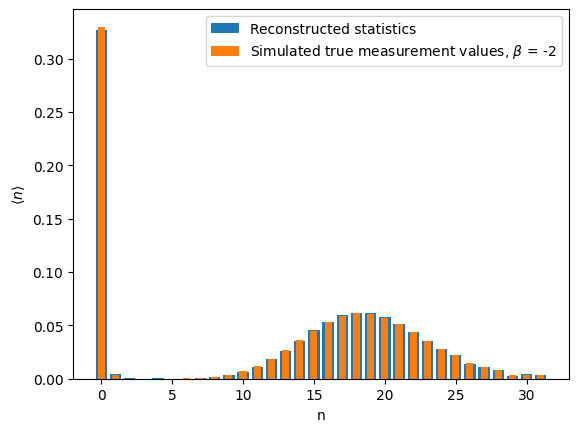

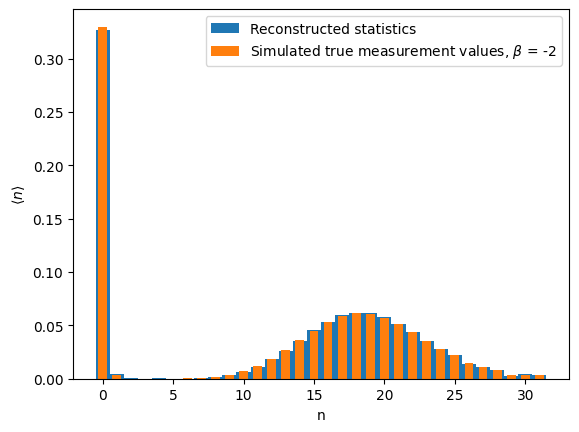

In [22]:
examples = 5

for i in range(examples):
    idx = np.random.choice(range(len(betas)))
    beta = betas[idx]
    measured = measured_populations[idx]
    plt.bar(indices, measure_population(beta, random_rho),
            label = "Reconstructed statistics",
            width=(i+1)/5)
    plt.bar(indices, measured,
            label = r"Simulated true measurement values, $\beta$ = {}".format(
                                                                 np.round(beta,
                                                                          2)),
                                                                 width=(i+1)/8)
    plt.xlabel(r"n")
    plt.ylabel(r"$\langle n \rangle$")
    
    plt.legend()
    plt.show()

# QuTiP details

In [23]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman and Simon Cross.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.6.1
Numpy Version:      1.19.2
Scipy Version:      1.5.2
Cython Version:     0.29.23
Matplotlib Version: 3.4.2
Python Version:     3.7.6
Number of CPUs:     6
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Darwin (x86_64)
Installation path:  /Users/shahnawaz/miniconda3/lib/python3.7/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qu

# Plot and save the wigner function for making animation of MLE

**make sure you have the images/wigner folder created**

In [24]:
# for i in range(len(rho_t)):
#     fig, ax = plt.subplots(1, 2, figsize=(15, 7))
#     indices = np.arange(hilbert_size)
    
#     plot_wigner(rho_t[i], fig, ax[0])
#     ax[0].scatter(np.real(betas), np.imag(betas), marker="x")
#     hinton(rho_t[i], ax=ax[1])
#     ax[1].set_title("Reconstructed Density matrix at iteration {}".format(str(i)))
#     plt.savefig("images/wigner/"+str(i)+".png", bbox_inches='tight')
#     plt.close()

# Make a gif with the Wigner plots

Install imageio for this to work

In [25]:
# import imageio

# png_dir = 'images/wigner/'
# images = []

# interval = 20 # intervals to pick to plot

# for i in range(0, len(rho_t), interval):
#     file_name = str(i)+".png"
#     file_path = os.path.join(png_dir, file_name)
#     images.append(imageio.imread(file_path))

# imageio.mimsave('reconstruction3.gif', images, loop=1) #make loop=0 to keep looping